In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from dataset import *
random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=50)
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[77.67562 82.52306]


## Train GAMI-Net 

In [4]:
model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=[40] * 5,
                         subnet_size_interaction=[40] * 5, 
                         max_epochs=[1000, 1000, 100],
                         learning_rates=[0.001, 0.001, 0.0001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=1,
                         loss_threshold=0.01,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.01972, validation loss: 0.01839: 100%|██████████| 12/12 [00:00<00:00, 110.22it/s]                       
Epoch:    2, train loss: 0.01824, validation loss: 0.01833: 100%|██████████| 12/12 [00:00<00:00, 116.17it/s]                       
Epoch:    3, train loss: 0.01799, validation loss: 0.01830: 100%|██████████| 12/12 [00:00<00:00, 117.38it/s]                       
Epoch:    4, train loss: 0.01786, validation loss: 0.01832: 100%|██████████| 12/12 [00:00<00:00, 128.63it/s]                       
Epoch:    5, train loss: 0.01795, validation loss: 0.01846: 100%|██████████| 12/12 [00:00<00:00, 128.67it/s]                       
Epoch:    6, train loss: 0.01799, validation loss: 0.01832: 100%|██████████| 12/12 [00:00<00:00, 129.51it/s]                       
Epoch:    7, train loss: 0.01803, validation loss: 0.01869: 100%|██████████| 12/12 [00:00<00:00, 128.76it/s]                       
Epoch:    8, train loss: 0.01795, validation loss: 0.01833: 100%|██████████|

Main Effect Training Stop at Epoch: 10, train loss: 0.01781, validation loss: 0.01843
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.01596, validation loss: 0.00809: 100%|██████████| 12/12 [00:00<00:00, 23.23it/s]                        
Epoch:    2, train loss: 0.00853, validation loss: 0.00756: 100%|██████████| 12/12 [00:00<00:00, 21.52it/s]                        
Epoch:    3, train loss: 0.00759, validation loss: 0.00752: 100%|██████████| 12/12 [00:00<00:00, 21.92it/s]                        
Epoch:    4, train loss: 0.00728, validation loss: 0.00731: 100%|██████████| 12/12 [00:00<00:00, 19.19it/s]                        
Epoch:    5, train loss: 0.00711, validation loss: 0.00668: 100%|██████████| 12/12 [00:00<00:00, 20.74it/s]                        
Epoch:    6, train loss: 0.00672, validation loss: 0.00677: 100%|██████████| 12/12 [00:00<00:00, 20.85it/s]                        
Epoch:    7, train loss: 0.00672, validation loss: 0.00646: 100%|██████████| 12/12 [00:00<00:00, 19.25it/s]                        
Epoch:    8, train loss: 0.00657, validation loss: 0.00648: 100%|██████████|

Interaction Training Stop at Epoch: 35, train loss: 0.00644, validation loss: 0.00637
#########################Stage 3: Fine Tuning#########################


Epoch:   1, train loss: 0.00604, validation loss: 0.00605: 100%|██████████| 12/12 [00:00<00:00, 19.25it/s]                         
Epoch:   2, train loss: 0.00603, validation loss: 0.00593: 100%|██████████| 12/12 [00:00<00:00, 19.42it/s]                         
Epoch:   3, train loss: 0.00596, validation loss: 0.00595: 100%|██████████| 12/12 [00:00<00:00, 20.96it/s]                         
Epoch:   4, train loss: 0.00594, validation loss: 0.00591: 100%|██████████| 12/12 [00:00<00:00, 23.07it/s]                         
Epoch:   5, train loss: 0.00595, validation loss: 0.00596: 100%|██████████| 12/12 [00:00<00:00, 23.12it/s]                         
Epoch:   6, train loss: 0.00591, validation loss: 0.00588: 100%|██████████| 12/12 [00:00<00:00, 22.76it/s]                         
Epoch:   7, train loss: 0.00589, validation loss: 0.00589: 100%|██████████| 12/12 [00:00<00:00, 23.38it/s]                         
Epoch:   8, train loss: 0.00590, validation loss: 0.00588: 100%|██████████| 

Fine Tuning Stop at Epoch: 35, train loss: 0.00579, validation loss: 0.00582


In [5]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[74.38529 76.02526]


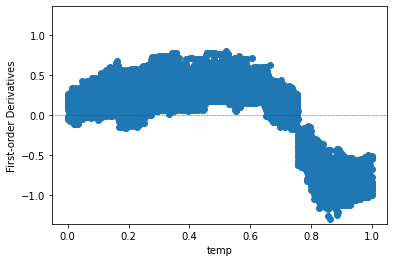

In [13]:
model.partial_derivatives(6)

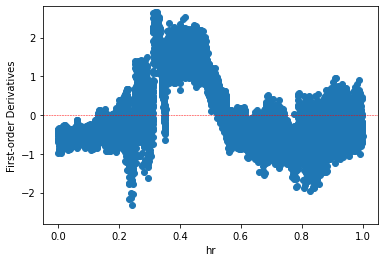

In [7]:
model.partial_derivatives(2)

In [8]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [9]:
model.get_clarity_loss(test_x)

0.000500036112498492

## Visualization

In [10]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

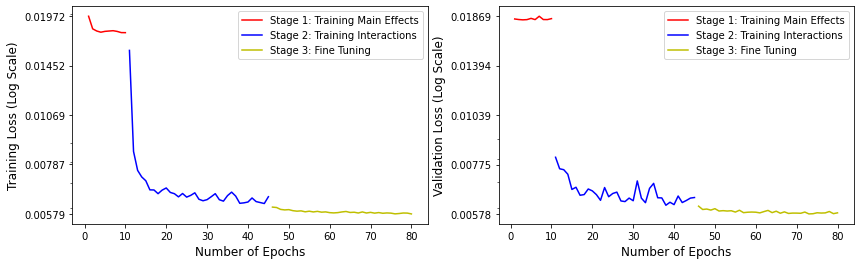

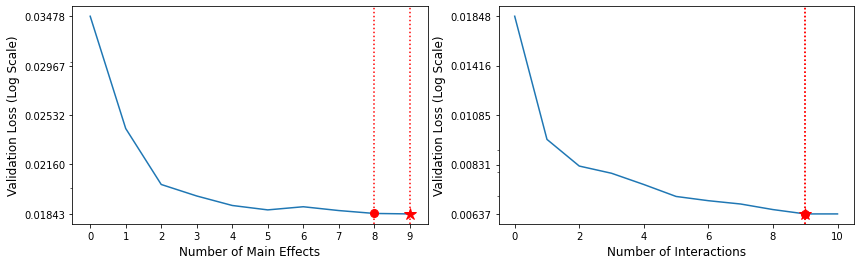

In [11]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

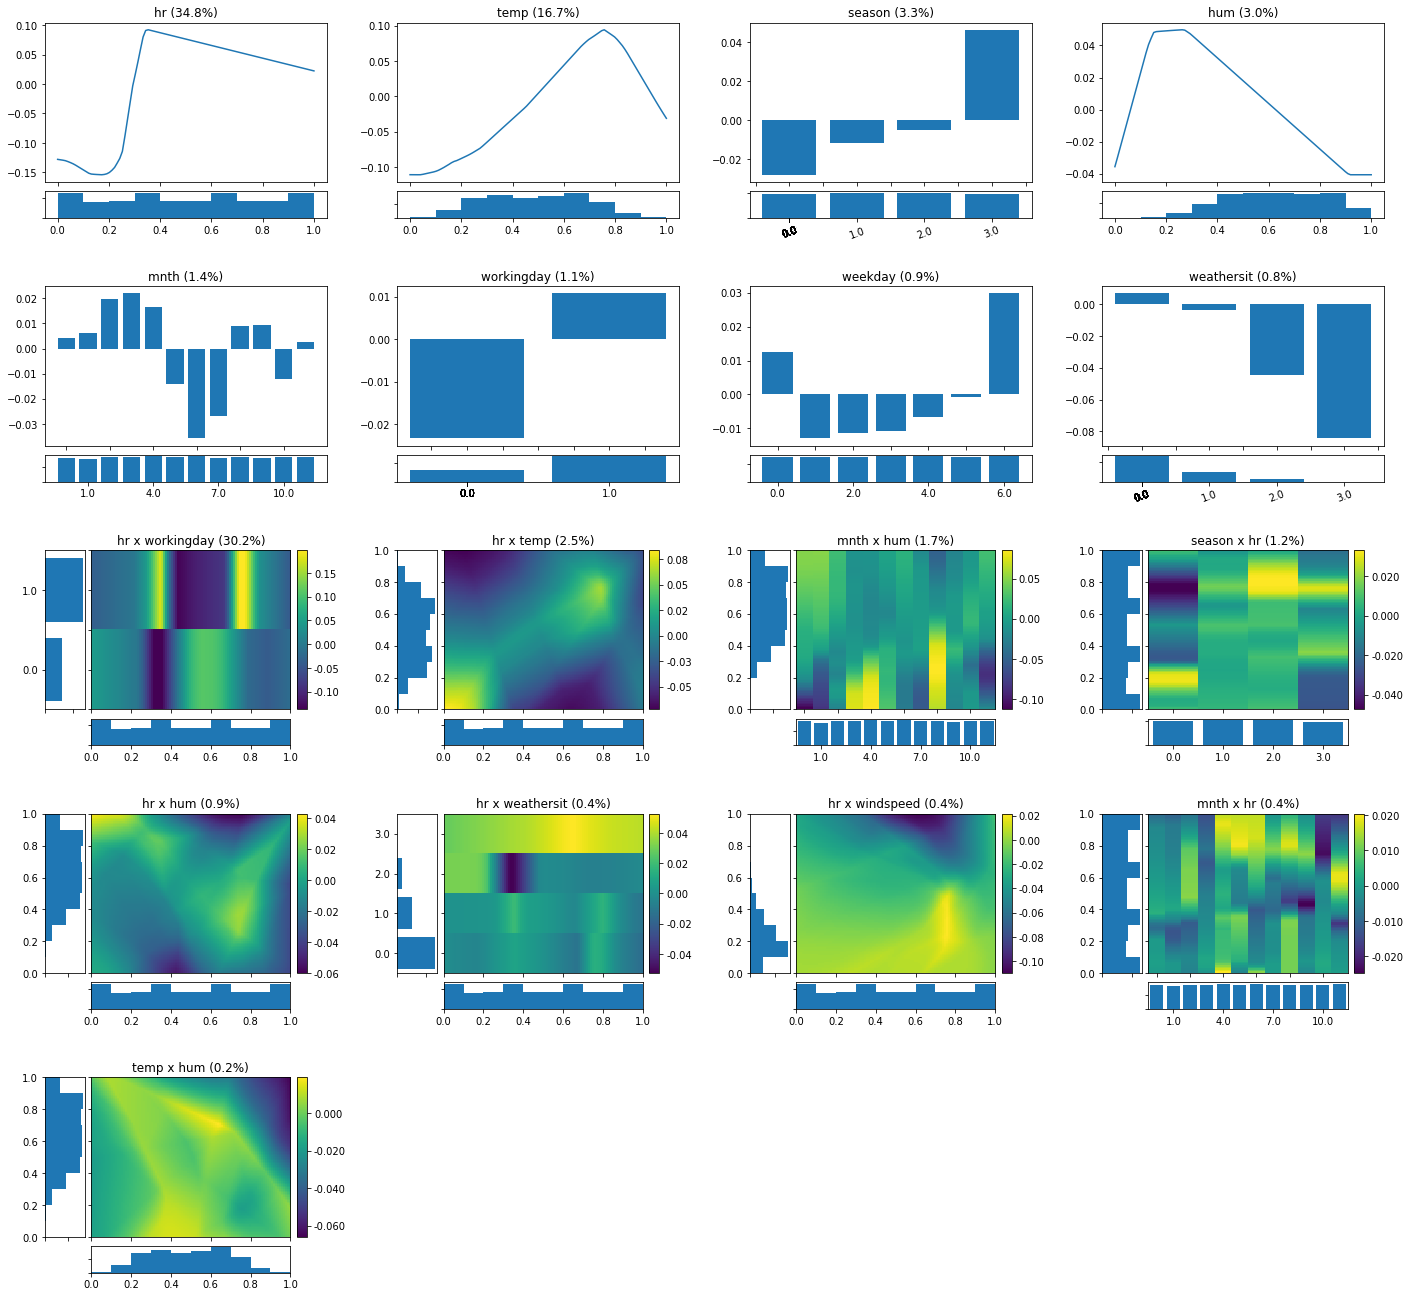

In [14]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=10, interaction_num=10, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

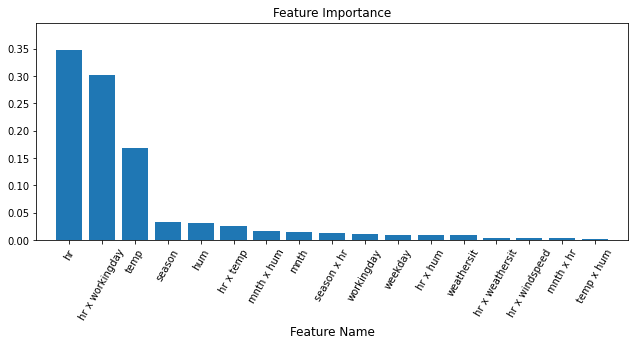

In [15]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [16]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

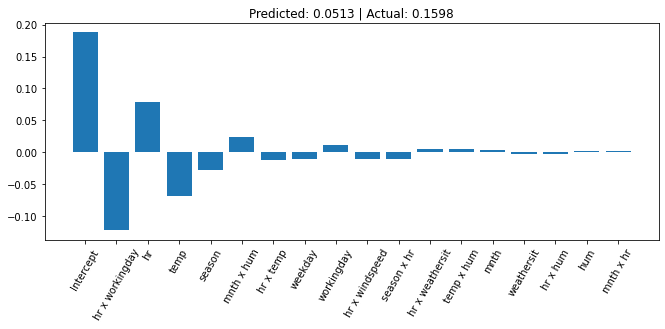

In [17]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [18]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

array([[ 0.05127838],
       [ 0.36647254],
       [ 0.26493096],
       ...,
       [-0.04298937],
       [ 0.05925723],
       [ 0.6036695 ]], dtype=float32)